# Oscillatory model

In [1]:
import numpy as np
import random
import bayesflow as bf

C:\Users\henry\missingness2\bayesflow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Simulator settings

In [2]:
def batch_prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


def batch_simulator(prior_samples, n_obs=41, t_end=10, sigma=0.05, missing_max=21, **kwargs):   
    """Simulate multiple oscillatory model data sets with missing values and time labels""" 

    n_sim = prior_samples.shape[0]   # batch size 
    n_missing = np.random.randint(0, missing_max+1)
    n_present = n_obs - n_missing
    sim_data = np.empty((n_sim, n_present, 2), dtype=np.float32)   # 1 batch consisting of n_sim data sets, each with n_present observations
    time_points = np.linspace(0, t_end, n_obs)
    
    for m in range(n_sim):        
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing)
        present_indices = np.setdiff1d(range(n_obs), missing_indices)
        present_timepoints = time_points[present_indices]
        sim_data[m, :, 0] = np.sin(a*2*np.pi*present_timepoints) + b + np.random.normal(0, sigma, size=n_present)
        sim_data[m, :, 1] = present_timepoints
        
    return sim_data

## Generative Model

In [3]:
model = bf.simulation.GenerativeModel(batch_prior, batch_simulator, prior_is_batched=True, simulator_is_batched=True)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 35, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


## Network setup

In [4]:
# Summary network
summary_net = bf.networks.TimeSeriesTransformer(
        input_dim=2,
        attention_settings=dict(num_heads=2, key_dim=16),
        dense_settings=dict(units=64, activation='relu'),
)

# Invertible network
inference_net = bf.networks.InvertibleNetwork(num_params=2, num_coupling_layers=4)

# Interface for density estimation and sampling
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

# Connect the networks with the generative model
trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=model,
    checkpoint_path = './Osc_timelabels_unnormalized_trafo_ckpts',
    max_to_keep=300
)

INFO:root:Loaded loss history from ./Osc_timelabels_unnormalized_trafo_ckpts\history_300.pkl.
INFO:root:Loaded simulation memory from ./Osc_timelabels_unnormalized_trafo_ckpts\memory.pkl
INFO:root:Networks loaded from ./Osc_timelabels_unnormalized_trafo_ckpts\ckpt-300
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Training

In [ ]:
# Online training 
losses = trainer.train_online(epochs=300, iterations_per_epoch=1000, batch_size=128, validation_sims=100)

In [5]:
# Load losses
losses = trainer.train_online(epochs=0, iterations_per_epoch=0, batch_size=128)

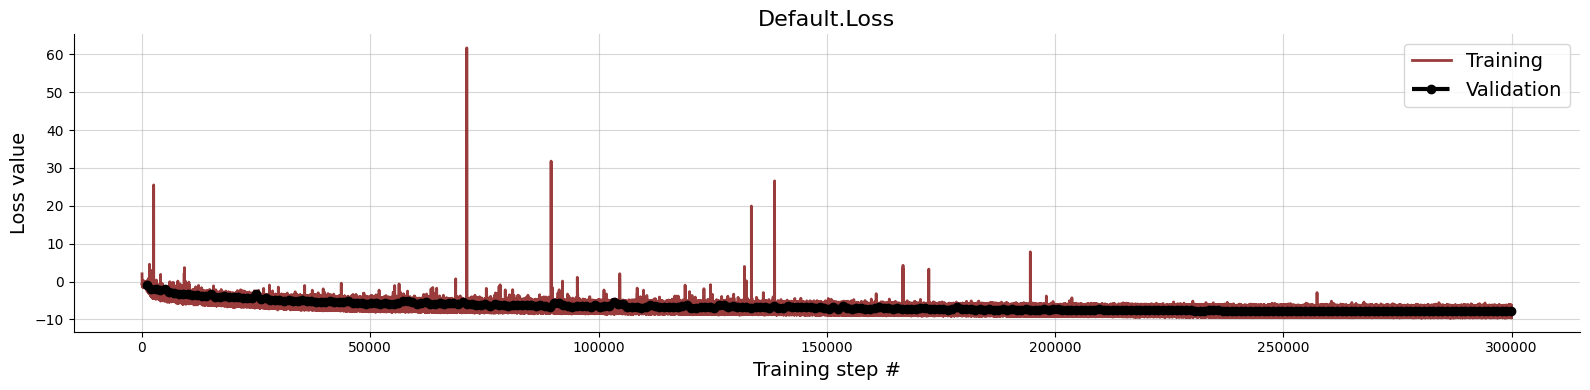

In [6]:
fig = bf.diagnostics.plot_losses(losses['train_losses'], losses['val_losses'])

## Validation

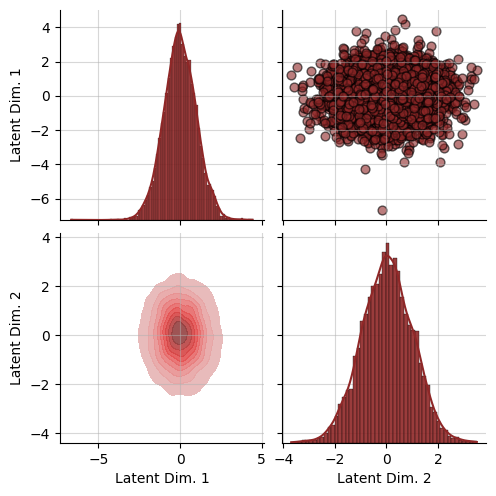

In [7]:
fig = trainer.diagnose_latent2d()

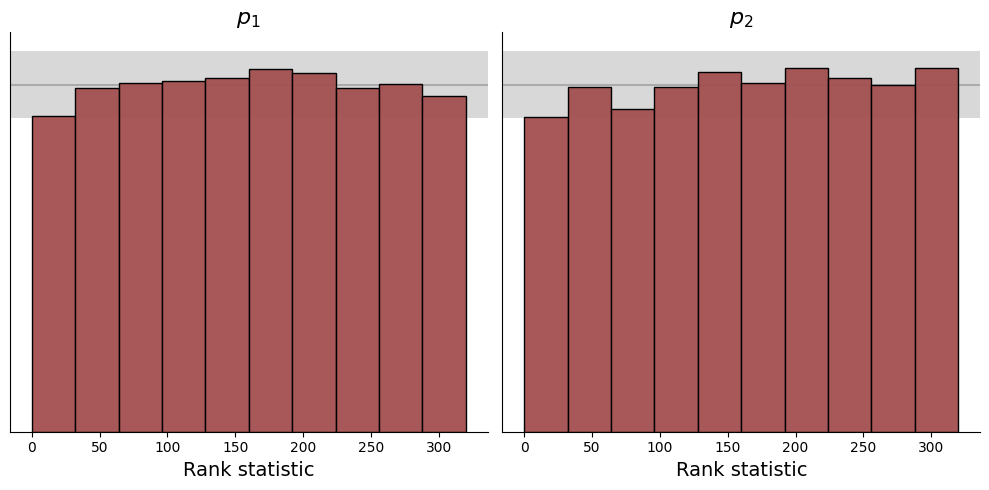

In [8]:
fig = trainer.diagnose_sbc_histograms()

In [9]:
new_sims = trainer.configurator(model(200))
posterior_draws = amortizer.sample(new_sims, n_samples=250)

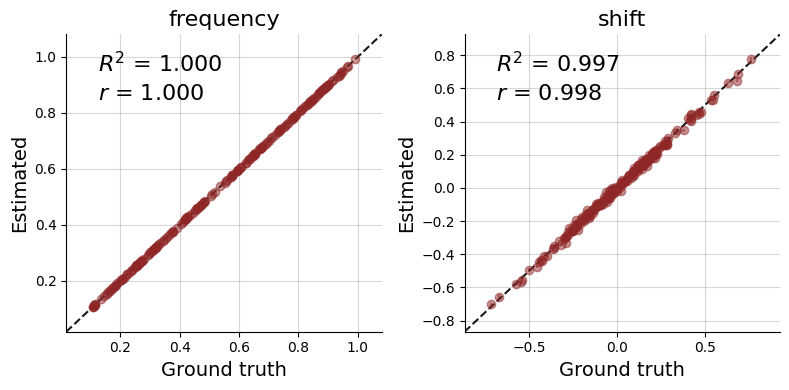

In [10]:
fig = bf.diagnostics.plot_recovery(posterior_draws, new_sims['parameters'], param_names=['frequency', 'shift'])

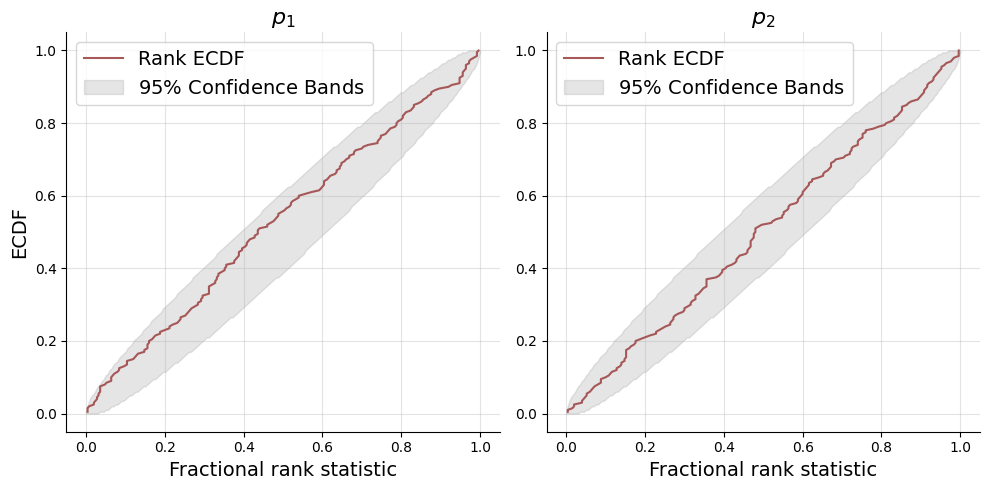

In [11]:
fig = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'])